# 完成不同case的UQ画图
## now we need to reduce the scatter size!

Figure saved → figs/NH3_NP_CF/1D_sim_uq_overlay_AH46.pdf


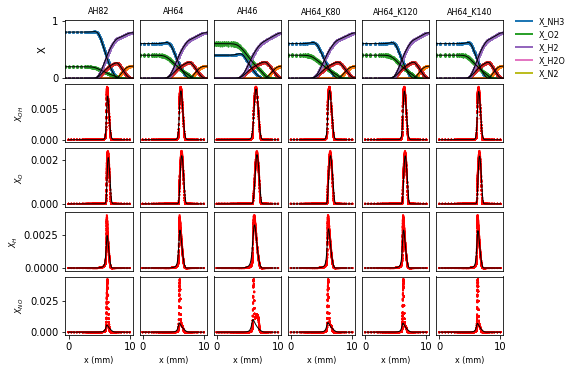

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Overlay CVODE profiles and Monte Carlo UQ‐input/output scatter using the actual grid
from each case’s uncertainty_inputs.csv and uncertainty_outputs.csv subfolders,
with distinct colors for the top‐species and a single‐column legend on the right.
"""

import os
from pathlib import Path
from typing import Sequence, Union, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def _as_list(val: Union[float, Sequence[float]], n: int) -> List[float]:
    if isinstance(val, (int, float)):
        return [float(val)] * n
    if len(val) != n:
        raise ValueError("Length of shift lists must match number of cases")
    return list(val)

def plot_sim_and_uq(
    sim_case_dir: str,
    uq_case_dir: str,
    fig_dir: str,
    target_cases: Sequence[str],
    top_species: Sequence[str]    = ("X_NH3", "X_O2", "X_H2", "X_H2O", "X_N2"),
    data_species: Sequence[str]   = ("X_OH", "X_O", "X_H", "X_NO", "Qdot"),
    x_range: Union[Sequence[float], None] = (0, 8),
    pdf_name: str                 = "1D_sim_uq_overlay.pdf",
    sim_color: str                = "black",
    uq_color: str                 = "steelblue",
    linewidth: float              = 1.0,
    marker_size: float            = 3,
    font_size: int                = 8,
    uq_marker: str                = "o",
    top_adjust: float             = 0.92,
    right_adjust: float             = 0.92,
    
):
    """
    Left column: CVODE spatial profiles
    Right column: Monte‐Carlo UQ scatter of inputs/outputs at each grid point.
    """
    # prepare distinct colors for each top_species
    cmap = plt.get_cmap('tab10')
    ts_colors = {sp: cmap(i / len(top_species)) for i, sp in enumerate(top_species)}

    n_cases = len(target_cases)
    n_rows  = len(data_species) + 1

    plt.rcParams.update({"font.size": font_size})
    fig, axs = plt.subplots(n_rows, n_cases,
                             figsize=(1.2 * n_cases, 1.1 * n_rows),
                             sharex=False, sharey=False)

    # Ensure 2D indexing for single‐case
    if n_cases == 1:
        axs = axs.reshape((n_rows,1))

    for col, case in enumerate(target_cases):
        # ── Load CVODE results ────────────────────────────────────────
        df_sim = pd.read_csv(Path(sim_case_dir) / f"{case}.csv")
        x_sim  = df_sim["grid"].to_numpy() * 1000  # mm

        # ── Load UQ inputs & outputs from case subfolder ─────────────
        in_csv  = Path(uq_case_dir) / case / "uncertainty_inputs.csv"
        out_csv = Path(uq_case_dir) / case / "uncertainty_outputs.csv"
        df_uq_in  = pd.read_csv(in_csv)
        df_uq_out = pd.read_csv(out_csv)
        x_uq = df_uq_in["grid"].to_numpy() * 1000  # mm

        # ── Top row: main‐species CVODE profiles + UQ‐input scatter ───
        ax_top = axs[0, col]
        for sp in top_species:
            ax_top.plot(
                x_sim, df_sim[sp].to_numpy(),
                color="black", linewidth=linewidth,
                label=sp if col==0 else ""
            )
            if sp in df_uq_in.columns:
                ax_top.scatter(
                    x_uq, df_uq_in[sp].to_numpy(),
                    marker=uq_marker, s=marker_size,
                    # facecolors="none", edgecolors=uq_color,
                    linewidths=linewidth,
                    # label="UQ inputs" if (sp==top_species[0] and col==0) else ""
                )

        ax_top.set_ylim(0,1.01)
        ax_top.set_xlim(*x_range)
        ax_top.set_title(f"{case}", fontsize=font_size)
        if col==0:
            ax_top.set_ylabel("X")
        else:
            ax_top.set_yticks([])
        ax_top.set_xticks([])

        # ── Lower rows: each data_species ─────────────────────────────
        for r, sp in enumerate(data_species, start=1):
            ax_sim = axs[r,  col]
            ax_sim.plot(
                x_sim, df_sim[sp].to_numpy(),
                color=sim_color, linewidth=linewidth,
                label="CVODE" if (r==1 and col==0) else ""
            )
            if sp in df_uq_out.columns:
                ax_sim.scatter(
                    x_uq, df_uq_out[sp].to_numpy(),
                    marker=uq_marker, s=marker_size,
                    facecolors="none", edgecolors=uq_color,
                    linewidths=linewidth, alpha=0.8,
                    # label="UQ outputs" if (r==1 and col==0) else ""
                )

            ylabel = "HRR (J/kg/s)" if sp=="Qdot" else sp
            if sp=="Qdot":
                ax_sim.set_yscale("log")
                ax_sim.set_ylim(1e6,1e10)
            if col == 0:
                # format y-labels: species with 'X_' get LaTeX subscripts, Qdot gets HRR label
                if sp == 'Qdot':
                    ax_sim.set_ylabel('HRR (J/kg/s)', fontsize=font_size)
                elif sp.startswith('X_'):
                    sub = sp.split('_', 1)[1]
                    ax_sim.set_ylabel(f"$X_{{{sub}}}$", fontsize=font_size)
                else:
                    ax_sim.set_ylabel(sp, fontsize=font_size)
            else:
                ax_sim.set_yticks([])

            if r==n_rows-1:
                ax_sim.set_xlabel("x (mm)", fontsize=font_size)
            else:
                ax_sim.set_xticks([])

    # ── Legend on the right ─────────────────────────────────────────
    handles = []
    labels  = []
    # one handle per top_species
    for sp in top_species:
        handles.append(Line2D([0],[0], color=ts_colors[sp], lw=2))
        labels.append(sp)
    # UQ inputs + outputs
    handles.append(Line2D([0],[0],
                          marker=uq_marker, linestyle="None",
                          markerfacecolor="none",
                          markeredgecolor=uq_color))
    # labels.append("UQ inputs")
    handles.append(Line2D([0],[0],
                          marker=uq_marker, linestyle="None",
                          markerfacecolor="none",
                          markeredgecolor=uq_color))
    # labels.append("UQ outputs")

    # place legend outside right in one column
    fig.legend(
        handles=handles,
        labels=labels,
        loc="center left",
        bbox_to_anchor=(0.98, 0.85),
        ncol=1,
        frameon=False,
        fontsize=font_size
    )

    plt.subplots_adjust(top=top_adjust, right=right_adjust, hspace=0.1, wspace=0.1)
    Path(fig_dir).mkdir(parents=True, exist_ok=True)
    out = Path(fig_dir) / pdf_name
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print(f"Figure saved → {out}")


plot_sim_and_uq(
    sim_case_dir = "SIM_results/NH3_NP_CF_reduce",
    uq_case_dir  = "figs/NH3_NP_CF/UQ_analysis",
    fig_dir      = "figs/NH3_NP_CF",
    target_cases=['AH82', 'AH64', 'AH46',
     'AH64_K80', 'AH64_K120', 'AH64_K140'],
    top_species  = ["X_NH3","X_O2","X_H2","X_H2O","X_N2"],
    data_species = ["X_OH","X_O","X_H", "X_NO"],
    x_range      = (0,8),
    pdf_name     = "1D_sim_uq_overlay_AH46.pdf",
    sim_color    = "black",
    uq_color     = "red",
    linewidth    = 1.0,
    marker_size  = 1,            # smaller scatter
    font_size    = 8,
    uq_marker    = "o",
    top_adjust   = 0.92,
    right_adjust = 0.97
)

# Plot the mean value and error bar


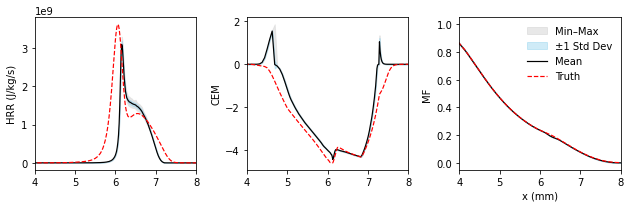

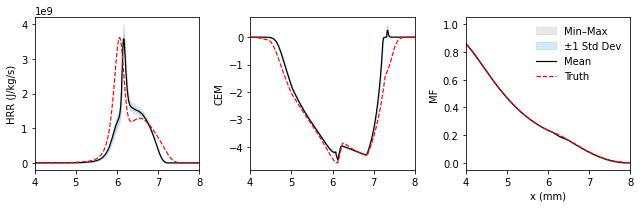

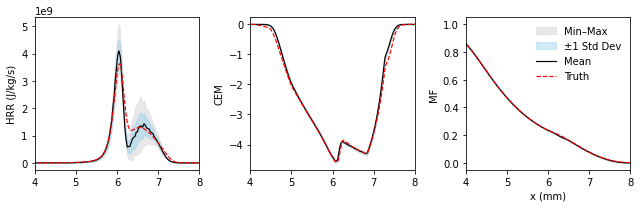

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_mean_with_errorbar(
    truth_file: str,
    iter_files_pattern: str,
    output_folder: str,
    output_name: str,
    species_to_plot=["HRR", "CEM", "MF"]
):
    # map species to y‐labels
    ylabel_map = {
        "HRR": r"HRR (J/kg/s)",
        "CEM": "CEM",
        "MF":  "MF"
    }

    # 1) gather files
    output_dir = Path(iter_files_pattern).parent
    iter_files = sorted(
        output_dir.glob("uncertainty_outputs_iter*.csv"),
        key=lambda p: int(re.search(r"iter(\d+)", p.name).group(1))
    )
    if not iter_files:
        raise ValueError("No iteration files found.")

    # 2) truth
    truth_df = pd.read_csv(truth_file, usecols=["grid"] + species_to_plot)
    grid_truth_mm = truth_df["grid"].values * 1000

    # 3) grid from iter
    df0 = pd.read_csv(iter_files[0], usecols=["grid"])
    grid_iter_mm = df0["grid"].values * 1000

    # 4) collect data
    all_iters = {sp: [] for sp in species_to_plot}
    for f in iter_files:
        df = pd.read_csv(f, usecols=species_to_plot)
        for sp in species_to_plot:
            all_iters[sp].append(df[sp].values)
    # convert to array
    data_arr = {sp: np.vstack(all_iters[sp]) for sp in species_to_plot}

    # 5) compute stats
    stats = {}
    for sp, arr in data_arr.items():
        stats[sp] = {
            "mean": arr.mean(axis=0),
            "std":  arr.std(axis=0),
            "min":  arr.min(axis=0),
            "max":  arr.max(axis=0)
        }

    # 6) plot subplots
    fig, axes = plt.subplots(
        1, len(species_to_plot),
        figsize=(3 * len(species_to_plot), 3),
        sharex=True
    )

    for ax, sp in zip(axes, species_to_plot):
        st = stats[sp]
        # min-max envelope
        ax.fill_between(
            grid_iter_mm,
            st["min"],
            st["max"],
            color="lightgray",
            alpha=0.5,
            label="Min–Max"
        )
        # ±1σ envelope
        ax.fill_between(
            grid_iter_mm,
            st["mean"] - st["std"],
            st["mean"] + st["std"],
            color="skyblue",
            alpha=0.4,
            label="±1 Std Dev"
        )
        # mean line
        ax.plot(
            grid_iter_mm,
            st["mean"],
            color="black",
            linewidth=1.2,
            label="Mean"
        )
        # truth line
        ax.plot(
            grid_truth_mm,
            truth_df[sp].values,
            color="red",
            linestyle="--",
            linewidth=1.2,
            label="Truth"
        )

        ax.set_ylabel(ylabel_map.get(sp, sp))
        ax.set_xlim(4, 8)
        ax.grid(False)
        # legend only on last
        if ax is axes[-1]:
            ax.legend(frameon=False)

    axes[-1].set_xlabel("x (mm)")
    plt.tight_layout()

    # 7) save
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    fig.savefig(Path(output_folder)/output_name, format="pdf", dpi=300, bbox_inches="tight")
    plt.show()
    

plot_mean_with_errorbar(
    truth_file="SIM_results/NH3_NP_CF_reduce/N_30.csv",
    iter_files_pattern="figs/NH3_NP_CF/UQ_analysis/N_30/outputs/uncertainty_outputs_iter*.csv",
    output_folder  ="figs/NH3_NP_CF",
    output_name    ="N_30_UQ_ori.pdf",
    species_to_plot=["HRR", "CEM", "MF"]
)

# Call the function
plot_mean_with_errorbar(
    truth_file="SIM_results/NH3_NP_CF_reduce/N_30.csv",
    iter_files_pattern="figs/NH3_NP_CF/UQ_NH_analysis_noise_10/N_30/outputs/uncertainty_outputs_iter*.csv",
    output_folder  ="figs/NH3_NP_CF",
    output_name    ="N_30_UQ_ori_NH.pdf",
    species_to_plot=["HRR", "CEM", "MF"]
)


plot_mean_with_errorbar(
    truth_file="SIM_results/NH3_NP_CF_reduce/N_30.csv",
    iter_files_pattern=(
        "figs/NH3_NP_CF/UQ_OH_analysis_noise_10/"
        "N_30/outputs/uncertainty_outputs_iter*.csv"
    ),
    output_folder  ="figs/NH3_NP_CF",
    output_name    ="N_30_UQ_ori_OH.pdf",
    species_to_plot=["HRR", "CEM", "MF"]
)

